<a href="https://colab.research.google.com/github/yahianassar2005/Food-vision-project/blob/main/Food_Vision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision project

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-36793f70-b8f1-2ebf-bd57-12b63bfc4b9c)


In [2]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/yahianassar2005/Food-vision-project/refs/heads/main/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2026-02-13 20:40:08--  https://raw.githubusercontent.com/yahianassar2005/Food-vision-project/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2026-02-13 20:40:08 (46.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
import tensorflow_datasets as tfds

datasets_list = tfds.list_builders()

target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [4]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.SP6POK_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.SP6POK_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 Dataset

In [7]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 31
  Class name (str form): donuts
        


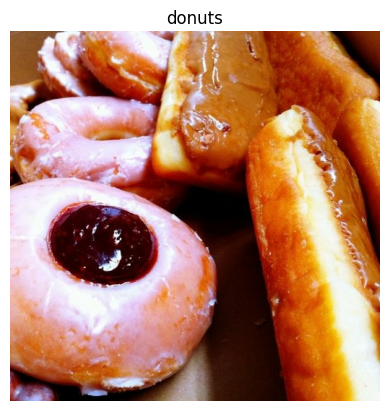

In [9]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions

In [10]:

def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [11]:
# Preprocess a single sample image and check the outputs
import tensorflow as tf

preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[1.34030609e+02 8.90306168e+01 5.80306129e+01]
  [1.36045914e+02 9.10459213e+01 6.00459175e+01]
  [1.37846939e+02 9.28469391e+01 6.38469391e+01]
  ...
  [1.30265366e+02 4.79183846e+01 1.62753057e+00]
  [1.30760223e+02 4.37602272e+01 4.59267795e-02]
  [1.34739838e+02 4.87398338e+01 1.73983324e+00]]

 [[1.41551025e+02 9.65510254e+01 6.55510254e+01]
  [1.49081650e+02 1.04081635e+02 7.30816345e+01]
  [1.51632660e+02 1.06632652e+02 7.56326523e+01]
  ...
  [1.30357101e+02 4.85713654e+01 1.99989128e+00]
  [1.34147995e+02 5.01479988e+01 4.14799976e+00]
  [1.33571289e+02 4.95712891e+01 3.57128906e+00]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


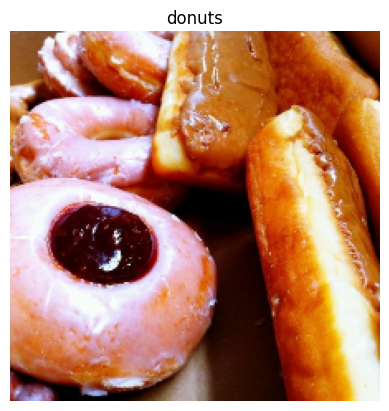

In [12]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare datasets

In [13]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [15]:
from helper_functions import create_tensorboard_callback

checkpoint_path = "fine_tune_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mized precision training

In [16]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [19]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [17]:
from tensorflow.keras import layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [37]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [20]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

## Fit the feature extraction model

In [21]:
tf.get_logger().setLevel('ERROR')

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20260213-205252
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 267s 86ms/step - accuracy: 0.4761 - loss: 2.2851 - val_accuracy: 0.6894 - val_loss: 1.1519
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 158s 66ms/step - accuracy: 0.6696 - loss: 1.2864 - val_accuracy: 0.7203 - val_loss: 1.0350
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 65ms/step - accuracy: 0.7061 - loss: 1.1333 - val_accuracy: 0.7296 - val_loss: 0.9909


In [22]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - accuracy: 0.7243 - loss: 1.0051


[1.0017033815383911, 0.7259405851364136]

## Load and evaluate checkpoint weights

In [25]:
# 1. Create a function to recreate the original model
def create_model():
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False


  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x)
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 76s 69ms/step - accuracy: 0.7242 - loss: 1.0067


In [26]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."

In [27]:
for layer in created_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_2 False float32 <DTypePolicy "mixed_float16">
rescaling_4 False float32 <DTypePolicy "mixed_float16">
normalization_2 False float32 <DTypePolicy "mixed_float16">
rescaling_5 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl

## Saving model

In [31]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision.keras"
model.save(save_dir)

In [36]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [33]:
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">

In [34]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 76s 70ms/step - accuracy: 0.7238 - loss: 1.0068


[1.0017033815383911, 0.7259405851364136]

In [35]:
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

## Preparing model's layers for fine-tuning

In [37]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2026-02-13 21:16:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  55.8MB/s    in 0.3s    

2026-02-13 21:16:25 (55.8 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [38]:
!mkdir downloaded_gs_model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [44]:
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

ValueError: File format not supported: filepath=downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [45]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. Turn on mixed precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# 2. Build the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# 3. Build the functional model
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(101)(x)

# 4. Separate activation layer for mixed precision (float32)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

# 5. Compile the model
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [46]:
history_101_food_classes_feature_extract = model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data))
)

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 237s 83ms/step - accuracy: 0.4735 - loss: 2.2883 - val_accuracy: 0.6994 - val_loss: 1.1363
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 159s 66ms/step - accuracy: 0.6689 - loss: 1.2840 - val_accuracy: 0.7201 - val_loss: 1.0289
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 159s 66ms/step - accuracy: 0.7038 - loss: 1.1272 - val_accuracy: 0.7240 - val_loss: 0.9954
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 157s 65ms/step - accuracy: 0.7269 - loss: 1.0365 - val_accuracy: 0.7278 - val_loss: 0.9760
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 158s 66ms/step - accuracy: 0.7438 - loss: 0.9693 - val_accuracy: 0.7370 - val_loss: 0.9655
